In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.regression.mixed_linear_model import MixedLM
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
df_goodreads = pd.read_csv('/content/drive/MyDrive/cleaned_goodreads_dataset - cleaned_goodreads_dataset.csv')

# Display the first few rows
df_goodreads.head()

,ID,Author,Title,URL,SeriesName,Summary,Genres,Score,RatingsCount,ReviewsCount,Pages,PublishedDate,Popularity_ReadingNow,Popularity_Wishlisted
0,35053870,sarina bowen,brooklynaire,https://www.goodreads.com/book/show/35053870-b...,Brooklyn Bruisers #4,"You’d think a billion dollars, a professional ...","Romance, Sports, Sports Romance, Contemporary,...",4.07,20705,2322,298,2018-02-12,2261,13100
1,28869598,sarina bowen,hard hitter,https://www.goodreads.com/book/show/28869598-h...,Brooklyn Bruisers #2,"He’s a fighter in the rink, but he’s about to ...","Romance, Sports, Sports Romance, Contemporary,...",4.05,10818,1049,336,2017-01-03,495,5907
2,30627346,sarina bowen,pipe dreams,https://www.goodreads.com/book/show/30627346-p...,Brooklyn Bruisers #3,"A goalie has to trust his instincts, even when...","Romance, Sports, Sports Romance, Contemporary,...",3.92,9532,975,336,2017-05-02,348,5180
3,17561022,j. clare,stranded with a billionaire,https://www.goodreads.com/book/show/17561022-s...,Billionaire Boys Club #1,The Billionaire Boys Club is a secret society ...,"Romance, Contemporary Romance, Contemporary, E...",3.82,14878,1009,215,2013-04-16,335,8684
4,43728457,j. clare,beauty and the billionaire,https://www.goodreads.com/book/show/43728457-b...,Dirty Fairy Tales #1,Ruthless Bastard. White Knight. But I just cal...,"Romance, Contemporary, Contemporary Romance, E...",3.85,9954,691,336,2019-01-27,15700,7770


# 1. Bayesian Averaging with Alternative Threshold Methods

In [3]:
# Calculate the global average score
global_avg_score = df_goodreads['Score'].mean()

# Calculate the median Ratings Count to use as threshold
threshold = df_goodreads['RatingsCount'].median()

print(f"Global Average Score: {global_avg_score}")
print(f"Median Ratings Count (Threshold): {threshold}")

Global Average Score: 3.989333333333333
Median Ratings Count (Threshold): 11558.0


In [4]:
def bayesian_average(row, C, m):
    R = row['Score']
    v = row['RatingsCount']
    return (v / (v + m)) * R + (m / (v + m)) * C

# Apply the Bayesian adjustment
df_goodreads['Bayesian_Score'] = df_goodreads.apply(
    bayesian_average, axis=1, C=global_avg_score, m=threshold)

# Display adjusted scores
df_goodreads[['Title', 'Score', 'Bayesian_Score']].head()

,Title,Score,Bayesian_Score
0,brooklynaire,4.07,4.041102
1,hard hitter,4.05,4.018664
2,pipe dreams,3.92,3.957997
3,stranded with a billionaire,3.82,3.894034
4,beauty and the billionaire,3.85,3.924861


In [5]:
from sklearn.model_selection import GridSearchCV

# Define a range of thresholds to test (10th to 90th percentile)
thresholds = np.percentile(df_goodreads['RatingsCount'], np.arange(10, 100, 10))

# Prepare data for cross-validation
X = df_goodreads[['RatingsCount']]
y = df_goodreads['Score']

# Initialize variables to store results
cv_scores = []
best_threshold = None
best_score = -np.inf

for m in thresholds:
    # Adjust scores with current threshold
    df_goodreads['Bayesian_Score_CV'] = df_goodreads.apply(
        bayesian_average, axis=1, C=global_avg_score, m=m)

    # Prepare data
    X_cv = df_goodreads[['Bayesian_Score_CV']]

    # Initialize linear regression model
    model = LinearRegression()

    # Perform cross-validation
    scores = cross_val_score(model, X_cv, y, cv=5, scoring='r2')
    mean_score = scores.mean()
    cv_scores.append(mean_score)

    # Update best threshold
    if mean_score > best_score:
        best_score = mean_score
        best_threshold = m

print(f"Best Threshold: {best_threshold}")
print(f"Best Cross-Validated R^2 Score: {best_score}")

Best Threshold: 719.4000000000001
Best Cross-Validated R^2 Score: 0.9295157239857534


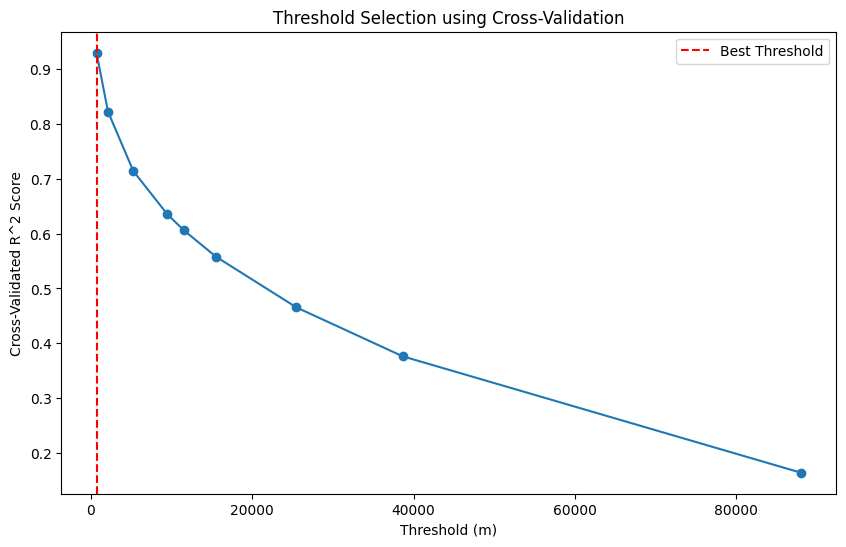

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(thresholds, cv_scores, marker='o')
plt.xlabel('Threshold (m)')
plt.ylabel('Cross-Validated R^2 Score')
plt.title('Threshold Selection using Cross-Validation')
plt.axvline(x=best_threshold, color='r', linestyle='--', label='Best Threshold')
plt.legend()
plt.show()

# Adjusting Weighting in Bayesian Formula

In [7]:
# Identify books with high scores but low ratings count
high_score_low_count = df_goodreads[(df_goodreads['Score'] > global_avg_score) &
                                    (df_goodreads['RatingsCount'] < threshold)]

# Define a function to adjust weights
def adjusted_bayesian_average(row, C, m, alpha=1):
    R = row['Score']
    v = row['RatingsCount']
    # Increase weight for high scores with low counts
    if (R > C) and (v < m):
        m_adjusted = m / alpha  # Reduce m to give more weight to R
    else:
        m_adjusted = m
    return (v / (v + m_adjusted)) * R + (m_adjusted / (v + m_adjusted)) * C

# Apply the adjusted Bayesian formula
df_goodreads['Bayesian_Score_Adjusted'] = df_goodreads.apply(
    adjusted_bayesian_average, axis=1, C=global_avg_score, m=best_threshold, alpha=2)

# Compare the scores
df_goodreads[['Title', 'Score', 'Bayesian_Score', 'Bayesian_Score_Adjusted']].head()

,Title,Score,Bayesian_Score,Bayesian_Score_Adjusted
0,brooklynaire,4.07,4.041102,4.067291
1,hard hitter,4.05,4.018664,4.046217
2,pipe dreams,3.92,3.957997,3.924866
3,stranded with a billionaire,3.82,3.894034,3.827810
4,beauty and the billionaire,3.85,3.924861,3.859391


# Handling Outliers and Influential Points

In [8]:
from scipy.stats.mstats import winsorize

# Winsorize RatingsCount at 1% and 99%
df_goodreads['RatingsCount_Winsorized'] = winsorize(df_goodreads['RatingsCount'], limits=[0.01, 0.01])

# Log-transform the winsorized RatingsCount
df_goodreads['Log_RatingsCount_Winsorized'] = np.log1p(df_goodreads['RatingsCount_Winsorized'])

# Update Bayesian adjustment using winsorized RatingsCount
df_goodreads['Bayesian_Score_Winsorized'] = df_goodreads.apply(
    bayesian_average, axis=1, C=global_avg_score, m=best_threshold)

In [9]:
import statsmodels.formula.api as smf

# Prepare data for robust regression
df_goodreads['Log_RatingsCount'] = np.log1p(df_goodreads['RatingsCount'])
df_goodreads['Log_ReviewsCount'] = np.log1p(df_goodreads['ReviewsCount'])
df_goodreads['Log_Popularity_Wishlisted'] = np.log1p(df_goodreads['Popularity_Wishlisted'])

# Define the formula
formula = 'Bayesian_Score_Adjusted ~ Log_RatingsCount + Log_ReviewsCount + Pages + Popularity_ReadingNow + Log_Popularity_Wishlisted'

# Fit robust linear model
rlm_model = smf.rlm(formula, data=df_goodreads).fit()
print(rlm_model.summary())

                       Robust linear Model Regression Results                      
Dep. Variable:     Bayesian_Score_Adjusted   No. Observations:                  105
Model:                                 RLM   Df Residuals:                       99
Method:                               IRLS   Df Model:                            5
Norm:                               HuberT                                         
Scale Est.:                            mad                                         
Cov Type:                               H1                                         
Date:                     Fri, 27 Sep 2024                                         
Time:                             13:13:12                                         
No. Iterations:                         14                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------

# Avoiding Overfitting in Regression Models

In [10]:
# Prepare predictors and target variable
X = df_goodreads[['Log_RatingsCount', 'Log_ReviewsCount', 'Pages', 'Popularity_ReadingNow', 'Log_Popularity_Wishlisted']]
y = df_goodreads['Bayesian_Score_Adjusted']

# Standardize predictors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Ridge Regression with Cross-Validation
ridge_cv = RidgeCV(alphas=np.logspace(-6, 6, 13), cv=5)
ridge_cv.fit(X_scaled, y)
print(f"Optimal alpha for Ridge Regression: {ridge_cv.alpha_}")

# Lasso Regression with Cross-Validation
lasso_cv = LassoCV(alphas=np.logspace(-6, 6, 13), cv=5)
lasso_cv.fit(X_scaled, y)
print(f"Optimal alpha for Lasso Regression: {lasso_cv.alpha_}")

# Compare models
ridge_coeffs = pd.Series(ridge_cv.coef_, index=X.columns)
lasso_coeffs = pd.Series(lasso_cv.coef_, index=X.columns)

print("Ridge Regression Coefficients:")
print(ridge_coeffs)
print("\nLasso Regression Coefficients:")
print(lasso_coeffs)


Optimal alpha for Ridge Regression: 100.0
Optimal alpha for Lasso Regression: 0.01
Ridge Regression Coefficients:
Log_RatingsCount             0.010915
Log_ReviewsCount             0.005422
Pages                        0.031403
Popularity_ReadingNow       -0.006374
Log_Popularity_Wishlisted    0.002705
dtype: float64

Lasso Regression Coefficients:
Log_RatingsCount             0.000000
Log_ReviewsCount             0.000000
Pages                        0.060805
Popularity_ReadingNow       -0.001769
Log_Popularity_Wishlisted   -0.000000
dtype: float64


# Assessing Multicollinearity

In [11]:
# Calculate VIF for each predictor
X_const = sm.add_constant(X)
vif_data = pd.DataFrame()
vif_data["feature"] = X_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]

print(vif_data)

                     feature        VIF
0                      const  55.498570
1           Log_RatingsCount  18.316740
2           Log_ReviewsCount  20.429328
3                      Pages   1.608176
4      Popularity_ReadingNow   1.833966
5  Log_Popularity_Wishlisted   5.402324


In [12]:
# Apply PCA to correlated variables
pca = PCA(n_components=1)
popularity_metrics = df_goodreads[['Log_RatingsCount', 'Log_ReviewsCount', 'Log_Popularity_Wishlisted']]
popularity_pca = pca.fit_transform(popularity_metrics)

# Add PCA component to dataframe
df_goodreads['Popularity_PCA'] = popularity_pca

# Re-define predictors
X_pca = df_goodreads[['Popularity_PCA', 'Pages', 'Popularity_ReadingNow']]

# Re-run regression
X_pca_const = sm.add_constant(X_pca)
model_pca = sm.OLS(y, X_pca_const).fit()
print(model_pca.summary())

                               OLS Regression Results                              
Dep. Variable:     Bayesian_Score_Adjusted   R-squared:                       0.185
Model:                                 OLS   Adj. R-squared:                  0.161
Method:                      Least Squares   F-statistic:                     7.663
Date:                     Fri, 27 Sep 2024   Prob (F-statistic):           0.000115
Time:                             13:15:17   Log-Likelihood:                 48.947
No. Observations:                      105   AIC:                            -89.89
Df Residuals:                          101   BIC:                            -79.28
Df Model:                                3                                         
Covariance Type:                 nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

# Non-Parametric Methods and Bootstrapping

In [13]:
# Calculate Spearman's correlation
corr_spearman, p_value = stats.spearmanr(df_goodreads['Bayesian_Score_Adjusted'], df_goodreads['RatingsCount'])
print(f"Spearman's Correlation: {corr_spearman}, P-value: {p_value}")

Spearman's Correlation: 0.26937590711175613, P-value: 0.005455986692072793


In [15]:
from sklearn.utils import resample

# Function to compute bootstrap confidence intervals
def bootstrap_ci(data, n_bootstrap=1000, ci=95):
    boot_means = []
    for _ in range(n_bootstrap):
        sample = resample(data)
        boot_means.append(np.mean(sample))
    lower = np.percentile(boot_means, (100 - ci) / 2)
    upper = np.percentile(boot_means, 100 - (100 - ci) / 2)
    return lower, upper

# Define ci in the global scope
ci = 95  # Confidence level

# Compute confidence intervals for adjusted scores
ci_lower, ci_upper = bootstrap_ci(df_goodreads['Bayesian_Score_Adjusted'], ci=ci)
print(f"{ci}% Confidence Interval for Bayesian Adjusted Score: [{ci_lower:.4f}, {ci_upper:.4f}]")

95% Confidence Interval for Bayesian Adjusted Score: [3.9712, 4.0362]


# Presenting Both Original and Adjusted Scores

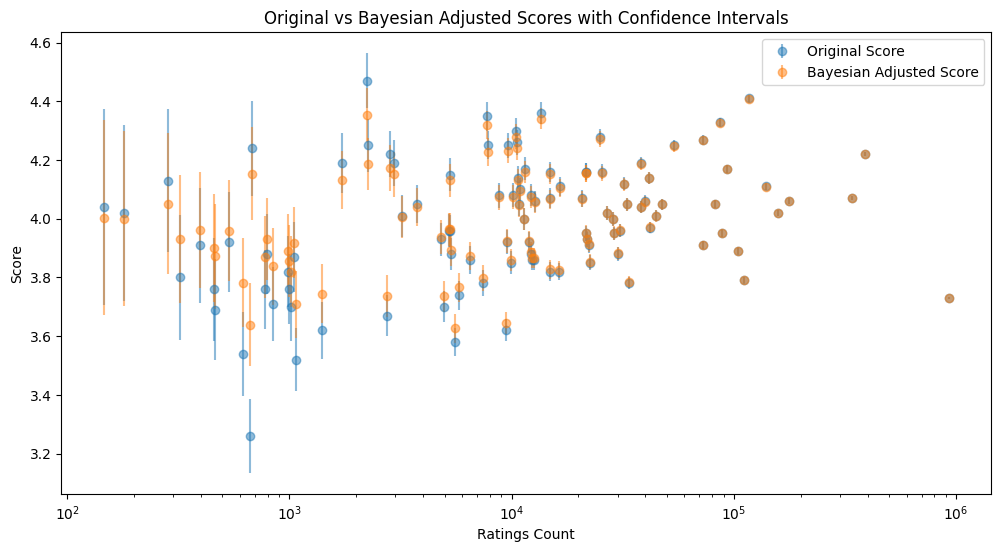

In [16]:
# Calculate standard errors
df_goodreads['Score_SE'] = df_goodreads['Score'] / np.sqrt(df_goodreads['RatingsCount'])
df_goodreads['Bayesian_Score_Adjusted_SE'] = df_goodreads['Bayesian_Score_Adjusted'] / np.sqrt(df_goodreads['RatingsCount'])

# Plotting Original vs Adjusted Scores with Error Bars
plt.figure(figsize=(12, 6))
plt.errorbar(df_goodreads['RatingsCount'], df_goodreads['Score'], yerr=df_goodreads['Score_SE'], fmt='o', alpha=0.5, label='Original Score')
plt.errorbar(df_goodreads['RatingsCount'], df_goodreads['Bayesian_Score_Adjusted'], yerr=df_goodreads['Bayesian_Score_Adjusted_SE'], fmt='o', alpha=0.5, label='Bayesian Adjusted Score')
plt.xscale('log')
plt.xlabel('Ratings Count')
plt.ylabel('Score')
plt.title('Original vs Bayesian Adjusted Scores with Confidence Intervals')
plt.legend()
plt.show()

# Model Validation and Selection
Using Cross-Validation and Information Criteria

In [18]:
from sklearn.model_selection import cross_val_score, KFold

# Initialize K-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Linear Regression Model
lm = LinearRegression()
cv_scores_lm = cross_val_score(lm, X_scaled, y, cv=kf, scoring='r2')
print(f"Linear Regression Cross-Validated R^2 Score: {cv_scores_lm.mean()}")

# Ridge Regression Cross-Validation Score
cv_scores_ridge = cross_val_score(ridge_cv, X_scaled, y, cv=kf, scoring='r2')
print(f"Ridge Regression Cross-Validated R^2 Score: {cv_scores_ridge.mean()}")

# Lasso Regression Cross-Validation Score
cv_scores_lasso = cross_val_score(lasso_cv, X_scaled, y, cv=kf, scoring='r2')
print(f"Lasso Regression Cross-Validated R^2 Score: {cv_scores_lasso.mean()}")

# Compare AIC and BIC
def calculate_aic_bic(model, X, y):
    n = len(y)
    p = X.shape[1]
    residuals = y - model.predict(X)
    sse = np.sum(residuals ** 2)
    aic = n * np.log(sse / n) + 2 * p
    bic = n * np.log(sse / n) + p * np.log(n)
    return aic, bic

# Calculate for Ridge Regression
aic_ridge, bic_ridge = calculate_aic_bic(ridge_cv, X_scaled, y)
print(f"Ridge Regression AIC: {aic_ridge}, BIC: {bic_ridge}")

# Calculate for Lasso Regression
aic_lasso, bic_lasso = calculate_aic_bic(lasso_cv, X_scaled, y)
print(f"Lasso Regression AIC: {aic_lasso}, BIC: {bic_lasso}")

Linear Regression Cross-Validated R^2 Score: 0.02020509724796744
Ridge Regression Cross-Validated R^2 Score: 0.0057373745387217625
Lasso Regression Cross-Validated R^2 Score: 0.06577755173364097
Ridge Regression AIC: -380.4483219393434, BIC: -367.17852018855575
Lasso Regression AIC: -384.1585107958058, BIC: -370.8887090450182


# Visualization Improvements

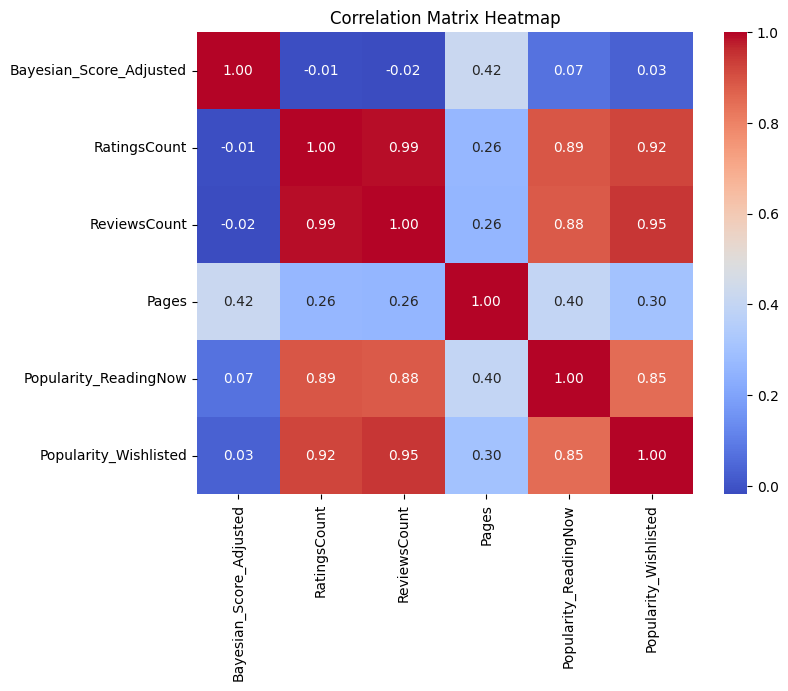

In [20]:
# Compute correlation matrix
corr_matrix = df_goodreads[['Bayesian_Score_Adjusted', 'RatingsCount', 'ReviewsCount', 'Pages', 'Popularity_ReadingNow', 'Popularity_Wishlisted']].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

# Bias Assessment

In [21]:
# Analyze distribution of authors
author_counts = df_goodreads['Author'].value_counts()
print("Top 10 Authors by Book Count:")
print(author_counts.head(10))

# Plot distribution of publication years
if 'PublicationYear' in df_goodreads.columns:
    plt.figure(figsize=(10, 6))
    df_goodreads['PublicationYear'].hist(bins=20)
    plt.xlabel('Publication Year')
    plt.ylabel('Number of Books')
    plt.title('Distribution of Publication Years')
    plt.show()
else:
    print("PublicationYear column not found for bias assessment.")

# Discuss implications
print("Observation: If a few authors or recent publication years dominate the dataset, this may introduce bias into the analysis. It's important to consider these factors when interpreting results.")

Top 10 Authors by Book Count:
Author
sarina bowen       3
kendra little      3
jennifer probst    3
laurelin paige     3
leslie north       3
diane alberts      3
melody anne        3
l. steele          3
sam crescent       3
sara cate          3
Name: count, dtype: int64
PublicationYear column not found for bias assessment.
Observation: If a few authors or recent publication years dominate the dataset, this may introduce bias into the analysis. It's important to consider these factors when interpreting results.
